# BRC algorithm tutorial

## MBNPy version

The code below is using BNS-JT module's **v1.0.0.**

In case the current version of BNS-JT module does not work, <br>
the version can be accessed by

```python
git clone --branch v1.0.0 https://github.com/jieunbyun/BNS-JT
```

or

```python
git checkout v1.0.0
```


In [1]:
import sys
sys.path.append(r"D:\MINJI\NETWORK RELIABILITY\BNS-JT-python")

import networkx as nx
import matplotlib.pyplot as plt
from BNS_JT import cpm, variable, operation
from networkx.algorithms.flow import shortest_augmenting_path
from BNS_JT import brc
import numpy as np

## User input: "coherent" system function

### Example: Network with five edges

#### Network topology
We analyse the network below.

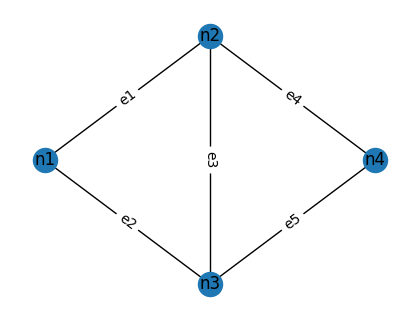

In [2]:
# Network
nodes = {'n1': (0, 0),
         'n2': (1, 1),
         'n3': (1, -1),
         'n4': (2, 0)}

edges = {'e1': ['n1', 'n2'],
	     'e2': ['n1', 'n3'],
	     'e3': ['n2', 'n3'],
	     'e4': ['n2', 'n4'],
	     'e5': ['n3', 'n4']}

%matplotlib inline
plt.figure(figsize=(4,3))
# Draw network
G = nx.Graph()
for node in nodes:
    G.add_node(node, pos=nodes[node])
for e, pair in edges.items():
    G.add_edge(*pair, label=e)

pos = nx.get_node_attributes(G, 'pos')
edge_labels=nx.get_edge_attributes(G, 'label')
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

#### Component events

The state of the five edges are represented by component events.<br>
The edges take binary-state, 0 for non-functional and 1 for functional.<br>

To use the BRC algorithm, component events need to be defined as a *variable.Variable* object.

In [3]:
varis = {}
for k, v in edges.items():
    varis[k] = variable.Variable( name=k, values = [0, 1]) # values: edge flow capacity

print(varis['e1'])

'Variable(name=e1, B=[{0}, {1}, {0, 1}], values=[0, 1])'


The probabilities of component events are defined as below:

In [4]:
probs = {'e1': {0: 0.01, 1: 0.99}, 'e2': {0: 0.01, 1: 0.99}, 'e3': {0: 0.05, 1: 0.95},
         'e4': {0: 0.05, 1: 0.95}, 'e5': {0: 0.10, 1: 0.90}}


#### System event

System state is evaluated by network connectivity between a designed origin-destination (OD) pair. <br>
In other words, a system state is survival if the OD pair is connected; and failure otherwise.

<div style="margin-top:0;">
This leads to the system function below. <br>
<b>NB1</b> <b>The first input</b> of a system function must be <b>a dictionary of components state.</b><br> 
<b>NB2</b> <b>The outputs</b> must be three: 
<ul style="margin-top:0;">
<li> <em>system value:</em> any format (does not affect the BRC algorithm; just for information's sake); </li>
<li> <em>system state:</em> a string, either 's' or 'f'; and </li>
<li> <em>components state that guarantees an obtained system state:</em> a dictionary of affecting components OR (if such information unavailable) None.</li>
</ul>
</div>

In [5]:
def net_conn(comps_st, od_pair, edges, varis): # maximum flow analysis

    G = nx.Graph()
    for k,x in comps_st.items():
        G.add_edge(edges[k][0], edges[k][1]) # we add each edge
        G[edges[k][0]][edges[k][1]]['capacity'] = varis[k].values[x] # define capacity as 0 if state = 0 or 1 if state = 1

    # perform maximum flow analysis between the OD pair
    G.add_edge(od_pair[1], 'new_d', capacity=1) # add a new edge with capacity 1 to ensure we find only ONE path. 
    f_val, f_dict = nx.maximum_flow(G, od_pair[0], 'new_d', capacity='capacity', flow_func=shortest_augmenting_path)

    if f_val > 0: # if the flow between the OD pair is greater than 0, the two nodes are connected
        sys_st = 's'

        # We can infer an associated minimum survival rule in case of network connectivity.
        min_comps_st = {} 
        for k, x in comps_st.items():
            k_flow = max([f_dict[edges[k][0]][edges[k][1]], f_dict[edges[k][1]][edges[k][0]]])
            if k_flow > 0: # the edges with flows > 0 consitute a minimum survival rule.
                min_comps_st[k] = 1

    else:
        sys_st = 'f'

        # In case of system failure, obtaining a minimum failure rule is not straightforward.
        min_comps_st = None

    return f_val, sys_st, min_comps_st


In this example, we consider the OD pair 'n1' and 'n4'.

In [6]:
od_pair=('n1','n4')

To run the BRC algorithm, a system function needs to have only one input **components state.**

This can be done using a lambda function.

In [7]:
sys_fun = lambda comps_st : net_conn(comps_st, od_pair, edges, varis)

Below are a few examples using the system function.

In [8]:
comps_st = {'e1': 1, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

1 s {'e1': 1, 'e4': 1}


In the result above, the components state leads to system survival.

We also have the survival rule that if e1 and e4 have a state no less than 1, the system survives regardless of the states of other components.

In [9]:
comps_st = {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

1 s {'e2': 1, 'e5': 1}


This time, we obtain a different survival rule because e1 has state 0 and therefore the previous rule no longer applies.

In [10]:
comps_st = {'e1': 0, 'e2': 0, 'e3': 1, 'e4': 1, 'e5': 1}
f_val, sys_st, min_comps_st = sys_fun(comps_st)
print(f_val, sys_st, min_comps_st)

0 f None


This case leads to system failure with e1 and e2 being dysfunctional. 

The minimum failure rule is returned None.

## Application of the BRC algorithm

Now we run the BRC algorithm.

Below, we set pf_bnd_wr = 0.0, indicating that the algorithm stops when the bound width on system failure probability is 0. <br>
In other words, the analysis aims for a complete (not approximate) analysis.

We set the other stopping criteria as max_sf=np.inf and max_nb=np.inf. <br>
The variables indicate the maximum number of system function runs and that of created branches <br>
Aiming for a complete analysis, we set both values to infinity. 

In [11]:
brs, rules, sys_res, monitor = brc.run(varis, probs, sys_fun, max_sf=np.inf, max_nb=np.inf, pf_bnd_wr=0.0)

*** Analysis completed with f_sys runs 8: out_flag = complete ***
The # of found non-dominated rules (f, s): 8 (4, 4)
Probability of branchs (f, s, u): (5.1688e-03, 9.95e-01, 0.0000e+00)
The # of branches (f, s, u), (min, avg) len of rf: 11 (5, 6, 0), (2, 2.50)


The algorithm stops after running the function 8 times, obtaining system failure probability as $5.16 \cdot 10^{-3}$.

The system function has 4 survival rules and 4 failure rules:

In [12]:
# Print survival rules
print("All Survival Rules:")
for i, rule in enumerate(rules['s'], 1):
    print(f"Rule {i}: {rule}")

# Print failure rules
print("\nAll Failure Rules:")
for i, rule in enumerate(rules['f'], 1):
    print(f"Rule {i}: {rule}")

All Survival Rules:
Rule 1: {'e1': 1, 'e4': 1}
Rule 2: {'e2': 1, 'e5': 1}
Rule 3: {'e2': 1, 'e3': 1, 'e4': 1}
Rule 4: {'e1': 1, 'e3': 1, 'e5': 1}

All Failure Rules:
Rule 1: {'e4': 0, 'e5': 0}
Rule 2: {'e1': 0, 'e2': 0}
Rule 3: {'e1': 0, 'e3': 0, 'e5': 0}
Rule 4: {'e2': 0, 'e3': 0, 'e4': 0}


The system event space is decomposed into 5 failure branches and 6 survival branches.

In [13]:
# Print branches
print("All Branches:")
for i, branch in enumerate(brs, 1):
    print(f"Branch {i}:")
    print(f"  Down: {branch.down}")
    print(f"  Up: {branch.up}")
    print(f"  Down State: {branch.down_state}")
    print(f"  Up State: {branch.up_state}")
    print(f"  Probability: {branch.p}\n")

All Branches:
Branch 1:
  Down: {'e1': 1, 'e2': 0, 'e3': 0, 'e4': 1, 'e5': 0}
  Up: {'e1': 1, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1}
  Down State: s
  Up State: s
  Probability: 0.9405

Branch 2:
  Down: {'e1': 1, 'e2': 1, 'e3': 0, 'e4': 0, 'e5': 1}
  Up: {'e1': 1, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 1}
  Down State: s
  Up State: s
  Probability: 0.0441045

Branch 3:
  Down: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 0}
  Up: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 1, 'e5': 1}
  Down State: s
  Up State: s
  Probability: 0.00893475

Branch 4:
  Down: {'e1': 1, 'e2': 0, 'e3': 0, 'e4': 0, 'e5': 0}
  Up: {'e1': 1, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 0}
  Down State: f
  Up State: f
  Probability: 0.00495

Branch 5:
  Down: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 0}
  Up: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 0}
  Down State: f
  Up State: f
  Probability: 4.7025000000000005e-05

Branch 6:
  Down: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 1}
  Up: {'e1': 0, 'e2': 1, 'e3': 1, 'e4': 0, 'e5': 1}
 

System failure probability is shown as below:

In [14]:
# System failure probability
P_f = sum(branch.p for branch in brs if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {P_f}")

System Failure Probability (P_f): 0.005168800000000001


One can do further analysis using the branches.

To this end, we can use *cpm* and *variable* objects.

In [15]:
from BNS_JT import cpm

In [16]:
varis['sys'] = variable.Variable(name='sys', values=['f', 's']) # state 0 for failure and 1 for survival

# probability distributions using CPM
cpms = {}

# component events
for k, v in edges.items():
    cpms[k] = cpm.Cpm( variables = [varis[k]], no_child=1, C = np.array([[0],[1]]), p=np.array([probs[k][0], probs[k][1]]) )

# system event
Csys, varis = brc.get_csys(brs, varis, {'f': 0, 's': 1})
print(Csys) # each branch becomes a row in the system's event matrix
psys = np.array([1.0]*len(Csys)) # the system function is determinisitic, i.e. all instances have a probability of 1.

cpms['sys'] = cpm.Cpm( [varis['sys']] + [varis[e] for e in edges], 1, Csys, psys )
print(cpms['sys'])

[[1 1 2 2 1 2]
 [1 1 1 2 0 1]
 [1 0 1 1 1 2]
 [0 1 2 2 0 0]
 [0 0 1 1 0 0]
 [1 0 1 1 0 1]
 [0 1 0 0 0 1]
 [1 1 0 1 0 1]
 [1 0 1 0 2 1]
 [0 0 0 2 2 2]
 [0 0 1 0 2 0]]
Cpm(variables=['sys', 'e1', 'e2', 'e3', 'e4', 'e5'], no_child=1, C=[[1 1 2 2 1 2]
 [1 1 1 2 0 1]
 [1 0 1 1 1 2]
 [0 1 2 2 0 0]
 [0 0 1 1 0 0]
 [1 0 1 1 0 1]
 [0 1 0 0 0 1]
 [1 1 0 1 0 1]
 [1 0 1 0 2 1]
 [0 0 0 2 2 2]
 [0 0 1 0 2 0]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


For instance, one can compute component importance $P(Xn=0 | S=0) = P(Xn=0, S=0) / P(S=0)$ as below.

In [17]:
def get_cim( comp_name, cpms, varis, pf ):
    var_elim_names = list(edges.keys())
    var_elim_names.remove(comp_name)

    var_elim_order = [varis[e] for e in var_elim_names]


    cpm_s_x = operation.variable_elim( cpms, var_elim_order )
    row_idx = np.where((cpm_s_x.C == [0, 0]).all(axis=1))
    p_s0_x0 = sum(cpm_s_x.p[row_idx])

    cim = p_s0_x0[0] / pf

    return cim


{'e1': 0.036316849613778325, 'e2': 0.03174317182244891, 'e3': 0.05992441881952915, 'e4': 0.9289231991721182, 'e5': 0.9344208522748271}


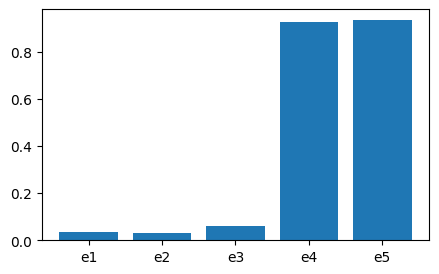

In [18]:
cims = {}
for comp_name in edges:
    cims[comp_name] = get_cim( comp_name, cpms, varis, pf = 5.4114e-03 )
print(cims)

fig, ax = plt.subplots(figsize=(5,3))
ax.bar( cims.keys(), cims.values() )
plt.show()